In [1]:
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# 共通関数っぽいもの

# ヒストグラムと出現回数
def hist_count( explanation, target_df):
  print("◆--- <", explanation, "> の出現頻度 ---◆" )
  target_df.hist()
  plt.show()
  print("")
  print( target_df.value_counts(sort=False) )
  print("◇----------◇")
  print("")

# DataFrame.info() の出力
def display_info( explanation, target_df ):
  print("◆--- <", explanation, " > ---◆" )
  print( target_df.info() )
  print("◇----------◇")
  print("")

# ndarray.info() の出力
def display_shape( explanation, target_array ):
  print("◆--- <", explanation, " > ---◆" )
  print( target_array.shape )
  print("◇----------◇")
  print("")

In [3]:
# csv の読み込み
df = pd.read_csv("./ks-projects-201801.csv")
display_info( "csv 読み上げ直後の df.info()", df )

# 目的変数となる 'state' 列が、'failed' or 'successful' の行のみを抽出し、'state'の値をboolに変換
df = df[df['state'].isin(['failed','successful'])]
#df["state"] = df["state"]=="successful"
df.loc[ df['state'] == 'failed', 'state'] = 0
df.loc[ df['state'] == 'successful', 'state'] = 1

# リークにならないよう参照不可の列と、IDを削除
df.drop( ['ID', 'backers', 'pledged', 'usd pledged', 'usd_pledged_real'], axis=1, inplace=True )
#display_info( "参照不可列の削除後の df.info()", df )
'''
  Int64Index: 331675 entries, 0 to 378660
  Data columns (total 10 columns):
  #   Column         Non-Null Count   Dtype  
  ---  ------         --------------   -----  
  0   name           331672 non-null  object 
  1   category       331675 non-null  object 
  2   main_category  331675 non-null  object 
  3   currency       331675 non-null  object 
  4   deadline       331675 non-null  object 
  5   goal           331675 non-null  float64
  6   launched       331675 non-null  object 
  7   state          331675 non-null  bool   
  8   country        331675 non-null  object 
  9   usd_goal_real  331675 non-null  float64
  dtypes: bool(1), float64(2), object(7)
'''


◆--- < csv 読み上げ直後の df.info()  > ---◆
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object

'\n  Int64Index: 331675 entries, 0 to 378660\n  Data columns (total 10 columns):\n  #   Column         Non-Null Count   Dtype  \n  ---  ------         --------------   -----  \n  0   name           331672 non-null  object \n  1   category       331675 non-null  object \n  2   main_category  331675 non-null  object \n  3   currency       331675 non-null  object \n  4   deadline       331675 non-null  object \n  5   goal           331675 non-null  float64\n  6   launched       331675 non-null  object \n  7   state          331675 non-null  bool   \n  8   country        331675 non-null  object \n  9   usd_goal_real  331675 non-null  float64\n  dtypes: bool(1), float64(2), object(7)\n'

◆--- < name の文字列長 > の出現頻度 ---◆


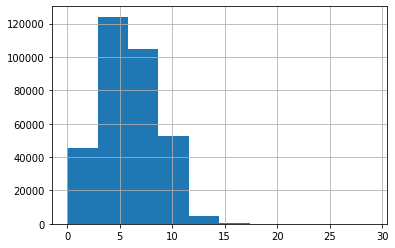


0         3
1     14957
2     30315
3     42587
4     41894
5     39641
6     37028
7     35442
8     32426
9     26376
10    17473
11     8553
12     3286
13     1023
14      365
15      174
16       86
17       25
18       14
19        3
20        1
21        1
27        1
29        1
Name: name, dtype: int64
◇----------◇

◆--- < category の単語数 > の出現頻度 ---◆


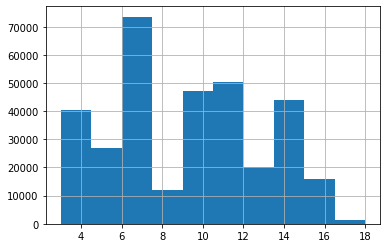


3     16269
4     24222
5     27014
6     35595
7     37963
8     11887
9     15841
10    31467
11    50327
12    16412
13     3604
14    43855
15     6175
16     9682
17     1020
18      342
Name: category, dtype: int64
◇----------◇

◆--- < launched から deadline までの日数 > の出現頻度 ---◆


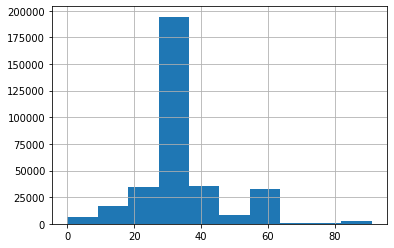


0       92
1      129
2      194
3      196
4      448
      ... 
87     105
88     378
89    1300
90     445
91      22
Length: 92, dtype: int64
◇----------◇

◆--- < 数値置き換え後の df.info()  > ---◆
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              331672 non-null  object 
 1   category          331675 non-null  object 
 2   main_category     331675 non-null  object 
 3   currency          331675 non-null  object 
 4   deadline          331675 non-null  object 
 5   goal              331675 non-null  float64
 6   launched          331675 non-null  object 
 7   state             331675 non-null  object 
 8   country           331675 non-null  object 
 9   usd_goal_real     331675 non-null  float64
 10  name_strlen       331675 non-null  int64  
 11  category_wordnum  331675 non-null  int64  
 12  days_left        

In [4]:
# 'name' の変換
def convert_name( df ):

  # 'name' は、単語数に置き換える
  converted = df["name"].fillna('').str.split().apply(len)
  hist_count( "name の文字列長", converted )
  return converted
  
# 'category' の変換
def convert_category( df ):

  # 'category' は、文字数に置き換える
  converted = df["category"].str.len()
  hist_count( "category の単語数", converted )
  return converted
  
# 'deadline', 'launched' の変換
def convert_deadline_launched( df ):

  # 'deadline', 'launched' は、日付の差分に置き換える
  converted = ( df['deadline'].apply(pd.to_datetime) - df['launched'].apply(pd.to_datetime) ).dt.days
  hist_count( "launched から deadline までの日数", converted )
  return converted


# 説明変数として扱えるよう、（無理矢理）数値に変換する
df["name_strlen"] = convert_name( df )
df["category_wordnum"] = convert_category( df )
df['days_left'] = convert_deadline_launched( df )
display_info( "数値置き換え後の df.info()", df )


In [5]:
# 訓練データ 80% 、テストデータ 20% となるように分割
df["state"] = df["state"].astype(int)
x_index = df.columns
x_dtype = df.dtypes
y_index = ["state"]
y_dtype = df["state"].dtype

X = df[x_index].values
y = df[y_index].values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# ndarray型よりも、DataFrame型の方が扱いやすいため、変換しておく
X_train_df = pd.DataFrame( data = X_train, columns = x_index )
X_test_df = pd.DataFrame( data = X_test, columns = x_index )
y_train_df = pd.DataFrame( data = y_train, columns = y_index )
y_test_df = pd.DataFrame( data = y_test, columns = y_index )

# dfの各列の型を、コピー
for column in x_index:
  X_train_df[column] = X_train_df[column].astype( df[column].dtype )
  X_test_df[column] = X_test_df[column].astype( df[column].dtype )
for column in y_index:
  y_train_df[column] = y_train_df[column].astype( df[column].dtype )
  y_test_df[column] = y_test_df[column].astype( df[column].dtype )

display_info( "訓練データの説明変数 X_train_df.info()", X_train_df )
display_info( "テストデータの説明変数 X_test_df.info()", X_test_df )
display_info( "訓練データの目的変数 y_train_df.info()", y_train_df )
display_info( "テストデータの目的変数 y_test_df.info()", y_test_df )



◆--- < 訓練データの説明変数 X_train_df.info()  > ---◆
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265340 entries, 0 to 265339
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              265338 non-null  object 
 1   category          265340 non-null  object 
 2   main_category     265340 non-null  object 
 3   currency          265340 non-null  object 
 4   deadline          265340 non-null  object 
 5   goal              265340 non-null  float64
 6   launched          265340 non-null  object 
 7   state             265340 non-null  int64  
 8   country           265340 non-null  object 
 9   usd_goal_real     265340 non-null  float64
 10  name_strlen       265340 non-null  int64  
 11  category_wordnum  265340 non-null  int64  
 12  days_left         265340 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 26.3+ MB
None
◇----------◇

◆--- < テストデータの説明変数 X_test_df.info()  > ---◆

Index(['goal', 'state', 'usd_goal_real', 'name_strlen', 'category_wordnum',
       'days_left'],
      dtype='object')

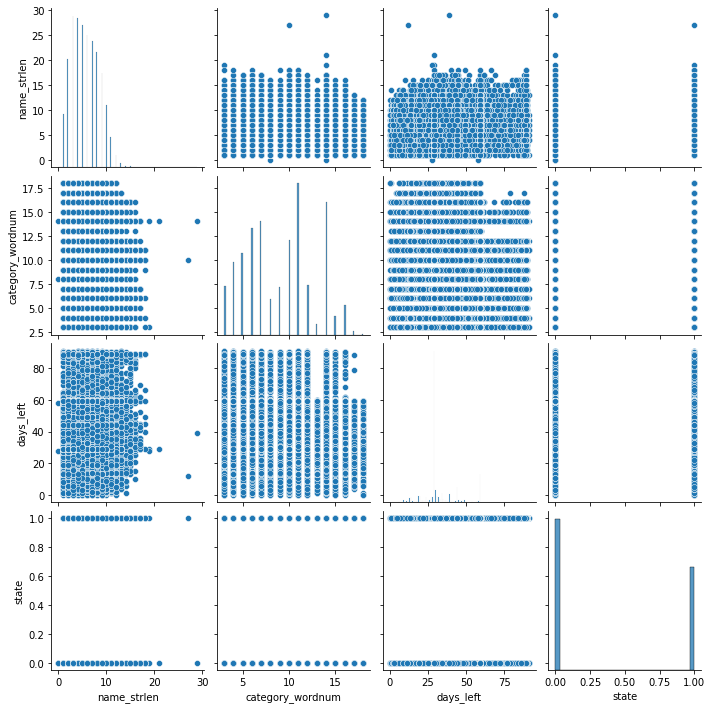

In [6]:
# 中川さんのノートブックを参考に、散布図を書いてみる
index_int = X_train_df.select_dtypes('number').columns
display(index_int)
if 1:
  sns.pairplot(X_train_df[["name_strlen","category_wordnum","days_left","state"]])
else:
  # 実行が完了しなかった。。。
  sns.pairplot(X_train_df[index_int])


'goal'

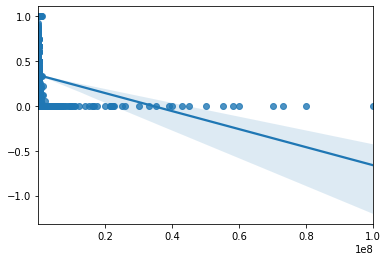

'state'

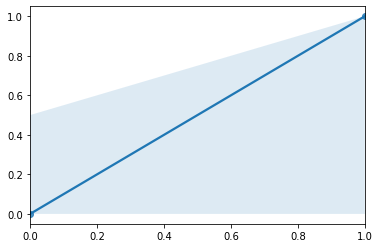

'usd_goal_real'

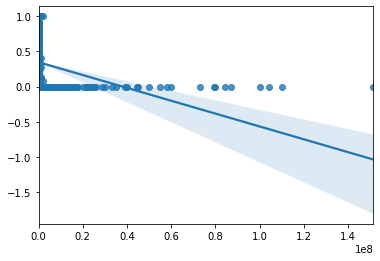

'name_strlen'

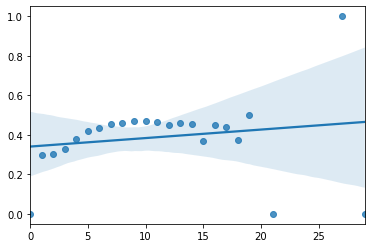

'category_wordnum'

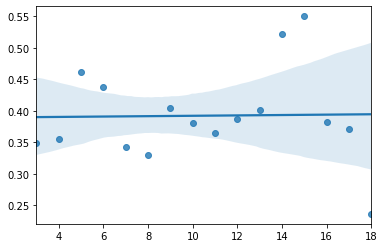

'days_left'

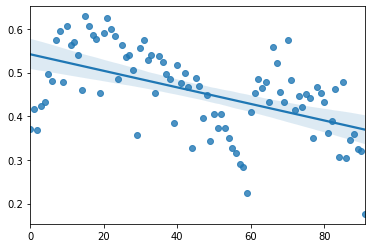

In [7]:
# 山崎さんのノートブックを参考にグラフを描画
for column in X_train_df.select_dtypes('number').columns:
  display(column)
  column_mean = X_train_df.groupby(column).state.mean()
  sns.regplot(x=column_mean.index.array, y=column_mean.values)
  plt.show()

In [8]:
# 小林さんのノートブックを参考に、ategory Encorders ライブラリを使ってみる。
!pip install category_encoders
import category_encoders as ce

     |████████████████████████████████| 81kB 2.2MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
# TargetEncoder による変換
def convert_by_te( explanatory, objective, X_train_df, X_test_df ):
  TE = ce.TargetEncoder()

  # リークしないよう、X_train_df を対象に fit_transform() を実行
  converted_train = TE.fit_transform(X_train_df[explanatory], X_train_df[objective])
  #display_info( "X_train_df." + explanatory + " から求めた *_te を X_train_df に追加", converted_train )

  # その結果を、X_test_df に、transform() で反映
  converted_test = TE.transform( X_test_df[explanatory] )
  #display_info( "X_train_df." + explanatory + " から求めた *_te を X_test_df に追加", converted_test )
  return converted_train, converted_test


In [10]:
# TargetEncoder を使って main_category, currency, country を変換
for cnv in [ "main_category", "currency", "country" ]:
  cnv_te = cnv + "_te"
  X_train_df[cnv_te], X_test_df[cnv_te] = convert_by_te( cnv, "state", X_train_df, X_test_df)
  
  # X_train, X_test にも、列を追加しておく
  if 0 :
    # つもりだったが、X_train, X_test は、後から *_df から再作成するため、ここでの辻褄合わせをやめる    
    X_train = np.append( X_train, X_train_df[cnv_te].values.reshape(-1,1), axis=1)
    X_test = np.append( X_test, X_test_df[cnv_te].values.reshape(-1,1), axis=1)

display_info( 'X_train_df', X_train_df )
display_shape( 'X_train', X_train )

display_info( 'X_test_df', X_test_df )
display_shape( 'X_test', X_test )


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


◆--- < X_train_df  > ---◆
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265340 entries, 0 to 265339
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              265338 non-null  object 
 1   category          265340 non-null  object 
 2   main_category     265340 non-null  object 
 3   currency          265340 non-null  object 
 4   deadline          265340 non-null  object 
 5   goal              265340 non-null  float64
 6   launched          265340 non-null  object 
 7   state             265340 non-null  int64  
 8   country           265340 non-null  object 
 9   usd_goal_real     265340 non-null  float64
 10  name_strlen       265340 non-null  int64  
 11  category_wordnum  265340 non-null  int64  
 12  days_left         265340 non-null  int64  
 13  main_category_te  265340 non-null  float64
 14  currency_te       265340 non-null  float64
 15  country_te        265340 non-null  float64

In [11]:
'''
◆--- < X_train_df  > ---◆
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265340 entries, 0 to 265339
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              265338 non-null  object 
 1   category          265340 non-null  object 
 2   main_category     265340 non-null  object 
 3   currency          265340 non-null  object 
 4   deadline          265340 non-null  object 
 5   goal              265340 non-null  float64
 6   launched          265340 non-null  object 
 7   state             265340 non-null  int64  
 8   country           265340 non-null  object 
 9   usd_goal_real     265340 non-null  float64
 10  name_strlen       265340 non-null  int64  
 11  category_wordnum  265340 non-null  int64  
 12  days_left         265340 non-null  int64  
 13  main_category_te  265340 non-null  float64
 14  currency_te       265340 non-null  float64
 15  country_te        265340 non-null  float64
dtypes: float64(5), int64(4), object(7)
memory usage: 32.4+ MB
None
◇----------◇
'''
# 数値以外の列は、何らかの変換を行っている。
# [0] name          -> [10] name_strlen
# [1] category      -> [11] category_wordnum
# [2] main_category -> [13] main_category_te
# [3] currency      -> [14] currency_te
# [4] deadline      -> [12] days_left
# [6] launched      -> [12] days_left
# [8] country       -> [15] country_te

# 16列のX_*_df から、目的変数のstate列と、数値以外の列の計8列を削除
for X_df in [X_train_df, X_test_df]:
  X_df.drop( ["state"], axis=1, inplace=True)
  X_df.drop( X_df.select_dtypes(exclude='number'), axis=1, inplace=True )
  display_info( 'state列と、数値以外の列を削除', X_df )

# 8列となった削除後のX_*_df(DataFrame型) から、X_*(ndarray型) を再作成
display_shape( "再作成前：X_train", X_train )
X_train = X_train_df.values
display_shape( "再作成後：X_train", X_train )

display_shape( "再作成前：X_test", X_test )
X_test = X_test_df.values
display_shape( "再作成後：X_test", X_test )


◆--- < state列と、数値以外の列を削除  > ---◆
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265340 entries, 0 to 265339
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   goal              265340 non-null  float64
 1   usd_goal_real     265340 non-null  float64
 2   name_strlen       265340 non-null  int64  
 3   category_wordnum  265340 non-null  int64  
 4   days_left         265340 non-null  int64  
 5   main_category_te  265340 non-null  float64
 6   currency_te       265340 non-null  float64
 7   country_te        265340 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 16.2 MB
None
◇----------◇

◆--- < state列と、数値以外の列を削除  > ---◆
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66335 entries, 0 to 66334
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   goal              66335 non-null  float64
 1   usd_goal_real     66

In [12]:
# 訓練データの標準化
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_train)


In [13]:
# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は分類なのでaccuracyを評価指標に指定
estimator = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
rfecv = RFECV(estimator, cv=10, scoring='accuracy')

# fitで特徴選択を実行
rfecv.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFECV(cv=10,
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=10000, n_iter_no_change=5, n_jobs=None,
                              penalty='none', power_t=0.5, random_state=1234,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [14]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))
display( X_train_df.columns )

Feature ranking: 
[6 5 2 3 4 1 8 7]


Index(['goal', 'usd_goal_real', 'name_strlen', 'category_wordnum', 'days_left',
       'main_category_te', 'currency_te', 'country_te'],
      dtype='object')

In [15]:
'''
Feature ranking: 
[6 5 2 3 4 1 8 7]
Index(['goal', 'usd_goal_real', 'name_strlen', 'category_wordnum', 'days_left',
       'main_category_te', 'currency_te', 'country_te'],
      dtype='object')
'''
# ↑ranking=1 となる列が複数あると期待していたが、バラバラなので、
# goal(6)、currency_te(8)、country_te(7) あたりを、落としてみるか？
low_rank = ["goal", "currency_te", "country_te"]
X_train2 = X_train_df.drop(low_rank, axis=1).values
X_test2 = X_test_df.drop(low_rank, axis=1).values
display_shape( "X_train2", X_train2 )
display_shape( "X_test2", X_test2 )


◆--- < X_train2  > ---◆
(265340, 5)
◇----------◇

◆--- < X_test2  > ---◆
(66335, 5)
◇----------◇



In [16]:
# 対数尤度と正答率を出力する
def display_result( model_name, answer, pred ):
  display( "★" + model_name  )
  display( '   ・対数尤度 = {:.3f}'.format(- log_loss(answer, pred)) )
  display( '   ・正答率   = {:.3f}%'.format(100 * accuracy_score(answer, pred) ) )

# 訓練データによる学習を行い、訓練誤差と汎化誤差を求める
def fit_predict( model_name, model, X_train, y_train, X_test, y_test ):

  # 訓練データによる学習
  model.fit( X_train, y_train )

  # 訓練誤差
  train_pred = model.predict( X_train )
  display_result( model_name + "（説明変数：" + str(X_train.shape[1]) + "個）の訓練誤差", y_train, train_pred )

  # 汎化誤差
  test_pred  = model.predict( X_test )
  display_result( model_name + "（説明変数：" + str(X_train.shape[1]) + "個）の汎化誤差", y_test, test_pred )


In [17]:
# ロジステック回帰
sdg = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-3)
fit_predict( "ロジスティック回帰", sdg, X_train, y_train, X_test, y_test )
fit_predict( "ロジスティック回帰", sdg, X_train2, y_train, X_test2, y_test )


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★ロジスティック回帰（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -14.405'

'   ・正答率   = 58.293%'

'★ロジスティック回帰（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -14.273'

'   ・正答率   = 58.675%'

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★ロジスティック回帰（説明変数：5個）の訓練誤差'

'   ・対数尤度 = -18.448'

'   ・正答率   = 46.588%'

'★ロジスティック回帰（説明変数：5個）の汎化誤差'

'   ・対数尤度 = -18.495'

'   ・正答率   = 46.452%'

In [18]:
# ランダムフォレスト
rndf = RandomForestClassifier(n_estimators=100, max_depth=5, criterion="entropy",
                             min_samples_leaf=5, min_samples_split=4, random_state=1234)

fit_predict( "ランダムフォレスト", rndf, X_train, y_train, X_test, y_test )
fit_predict( "ランダムフォレスト", rndf, X_train2, y_train, X_test2, y_test )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


'★ランダムフォレスト（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -11.677'

'   ・正答率   = 66.191%'

'★ランダムフォレスト（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -11.588'

'   ・正答率   = 66.451%'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


'★ランダムフォレスト（説明変数：5個）の訓練誤差'

'   ・対数尤度 = -11.756'

'   ・正答率   = 65.964%'

'★ランダムフォレスト（説明変数：5個）の汎化誤差'

'   ・対数尤度 = -11.645'

'   ・正答率   = 66.283%'

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★アダブースト（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -10.415'

'   ・正答率   = 69.845%'

'★アダブースト（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -10.980'

'   ・正答率   = 68.211%'

array([0.13768192, 0.31205819, 0.10303817, 0.11841824, 0.14130133,
       0.12675716, 0.01919361, 0.0415514 ])

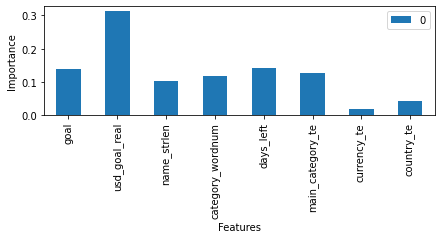

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★アダブースト（説明変数：5個）の訓練誤差'

'   ・対数尤度 = -10.539'

'   ・正答率   = 69.486%'

'★アダブースト（説明変数：5個）の汎化誤差'

'   ・対数尤度 = -11.039'

'   ・正答率   = 68.038%'

array([0.43582577, 0.12292378, 0.14420684, 0.15402465, 0.14301895])

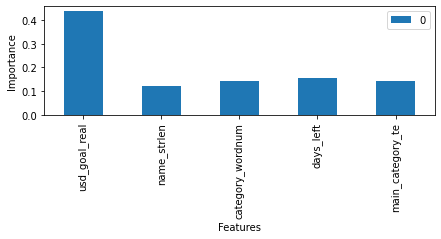

In [19]:
# アダブーストの説明変数の重要度を出力する
def display_importance( model, columns ):
  # scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
  display(model.feature_importances_)
  pd.DataFrame(model.feature_importances_, index=columns).plot.bar(figsize=(7,2))
  plt.ylabel("Importance")
  plt.xlabel("Features")
  plt.show()

# アダブースト
adab = AdaBoostClassifier(DecisionTreeClassifier(
                          max_depth=5,
                          min_samples_leaf=5,
                          min_samples_split=4, 
                          random_state=1234,
                          criterion="entropy"),
                          n_estimators=100, random_state=1234)

fit_predict( "アダブースト", adab, X_train, y_train, X_test, y_test )
display_importance( adab, X_train_df.columns )

fit_predict( "アダブースト", adab, X_train2, y_train, X_test2, y_test )
display_importance( adab, X_train_df.drop(low_rank, axis=1).columns )


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★アダブースト（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -10.415'

'   ・正答率   = 69.845%'

'★アダブースト（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -10.980'

'   ・正答率   = 68.211%'

array([0.13768192, 0.31205819, 0.10303817, 0.11841824, 0.14130133,
       0.12675716, 0.01919361, 0.0415514 ])

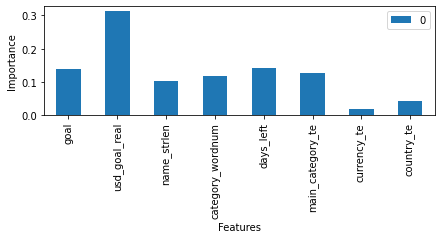

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★アダブースト（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -10.415'

'   ・正答率   = 69.845%'

'★アダブースト（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -10.980'

'   ・正答率   = 68.211%'

array([0.13768192, 0.31205819, 0.10303817, 0.11841824, 0.14130133,
       0.12675716, 0.01919361, 0.0415514 ])

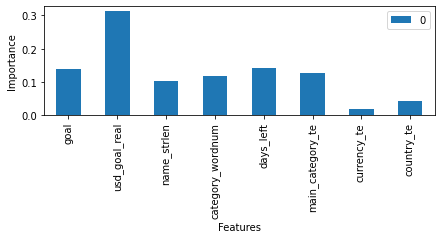

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★アダブースト（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -10.613'

'   ・正答率   = 69.272%'

'★アダブースト（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -10.900'

'   ・正答率   = 68.442%'

array([0.15183062, 0.27301793, 0.08732081, 0.15032712, 0.13775961,
       0.14962825, 0.01494128, 0.03517438])

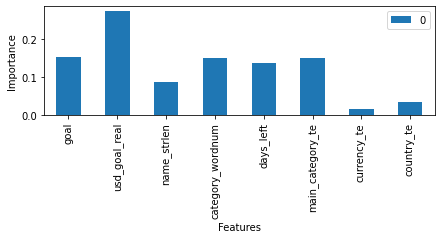

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★アダブースト（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -10.420'

'   ・正答率   = 69.831%'

'★アダブースト（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -10.921'

'   ・正答率   = 68.382%'

array([0.15861165, 0.32457652, 0.0920256 , 0.12744021, 0.12448657,
       0.12126024, 0.01584382, 0.03575539])

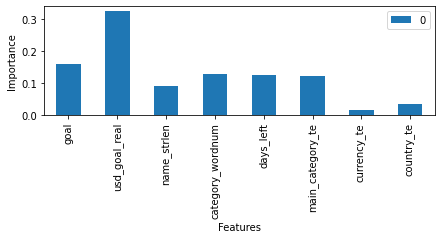

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'★アダブースト（説明変数：8個）の訓練誤差'

'   ・対数尤度 = -10.031'

'   ・正答率   = 70.959%'

'★アダブースト（説明変数：8個）の汎化誤差'

'   ・対数尤度 = -11.070'

'   ・正答率   = 67.949%'

array([0.14969166, 0.36164637, 0.10301757, 0.10556577, 0.12423697,
       0.10807379, 0.01545092, 0.03231695])

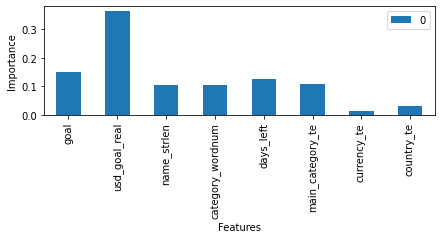

In [20]:
# アダブーストのチューニング
def adaboost_try( X_train, y_train, X_test, y_test, depth, leaf, split, estimators ):
  adab = AdaBoostClassifier(DecisionTreeClassifier(
                          max_depth=depth,
                          min_samples_leaf=leaf,
                          min_samples_split=split, 
                          random_state=1234,
                          criterion="entropy"),
                          n_estimators=estimators, random_state=1234)

  fit_predict( "アダブースト", adab, X_train, y_train, X_test, y_test )
  display_importance( adab, X_train_df.columns )

adaboost_try( X_train, y_train, X_test, y_test, 5, 5, 4, 100 )
adaboost_try( X_train, y_train, X_test, y_test, 5, 5, 5, 100 )
adaboost_try( X_train, y_train, X_test, y_test, 4, 5, 5, 100 )
adaboost_try( X_train, y_train, X_test, y_test, 4, 5, 5, 200 )
adaboost_try( X_train, y_train, X_test, y_test, 4, 5, 5, 500 )



私が試した中で、一番成績が良かった成績は、以下のものです。
>　★アダブースト（説明変数：8個）の汎化誤差
>   ・対数尤度 = -10.900
>   ・正答率   = 68.442%